<a href="https://colab.research.google.com/github/Andrea039/prueba1/blob/master/GatosCategorias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../content/drive/My Drive/gatos"))

['.ipynb_checkpoints', 'catesfinge.01.jpg', 'catesfinge.02.jpg', 'catesmok.01.jpg', 'catorange.01.jpg', 'catsangora.02.jpg', 'catsiames.02.jpg', 'catsmok.02.jpg', 'catsangora.01.jpg', 'catsiames.01.jpg', 'catorange.02.jpg']


Define constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

**Prepare Traning Data**

In [10]:

filenames = os.listdir("../content/drive/My Drive/gatos")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'catesfinge':
        categories.append(1)
    elif category == 'catsiames':
        categories.append(2)
    elif category == 'catorange':
        categories.append(3)
    elif category == 'catsmok':
        categories.append(4)
    else:
        categories.append(5)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [13]:
df.head(15)

,filename,category
0,.ipynb_checkpoints,5
1,catesfinge.01.jpg,1
2,catesfinge.02.jpg,1
3,catesmok.01.jpg,5
4,catorange.01.jpg,3
5,catsangora.02.jpg,5
6,catsiames.02.jpg,2
7,catsmok.02.jpg,4
8,catsangora.01.jpg,5
9,catsiames.01.jpg,2


**See Total In count**

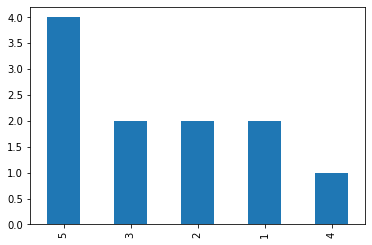

In [14]:
df['category'].value_counts().plot.bar()

**See sample image**

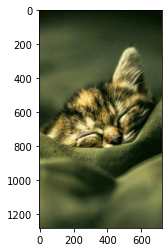

In [19]:
sample = random.choice(filenames)
image = load_img("../content/drive/My Drive/gatos/"+ sample)
plt.imshow(image)

**Build Model**

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

**Callbacks**

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

***Early Stop***

In [22]:
earlystop = EarlyStopping(patience=10)

***Learning Rate Reduction***

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
callbacks = [earlystop, learning_rate_reduction]

**Prepare data**

In [25]:
df["category"] = df["category"].replace({0: 'catesfinge', 1: 'catsiames', 2: 'catorange', 3:'catsmok', 4:'catangora' }) 

In [26]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

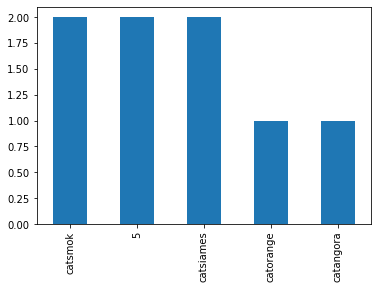

In [27]:
train_df['category'].value_counts().plot.bar()

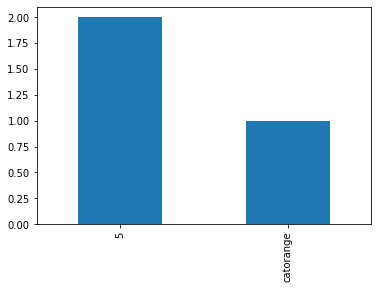

In [28]:
validate_df['category'].value_counts().plot.bar()

In [29]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

**Traning Generator**

In [45]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../content/drive/My Drive/gatos/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    #clases = {'catesfinge','catsiames', 'catorange', 'catsmok', 'catangora'}, 
    batch_size=batch_size
)

Found 8 validated image filenames.


**Validation Generator**

In [50]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../content/drive/My Drive/gatos/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 2 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


**See how our generator work**

In [59]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../content/drive/My Drive/gatos/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='raw'
)

Found 1 validated image filenames.


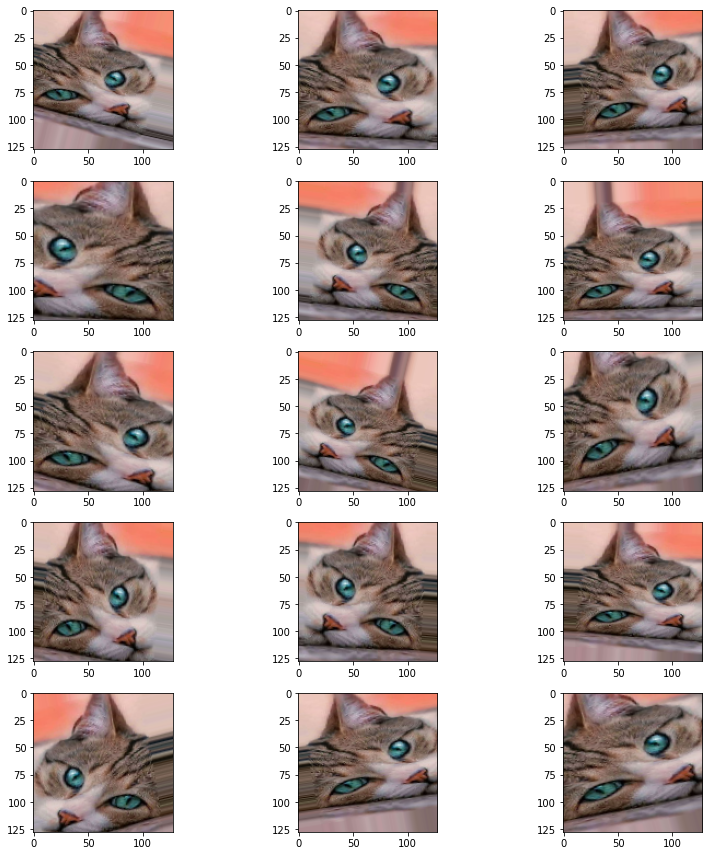

In [51]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Fit Model**

In [54]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

ValueError: ignored